In [1]:
# Imgae Captioning dependencies ###################################################################
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle
# Translation dependencies ########################################################################
from selenium import webdriver
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import clipboard
# TTS dependencies ################################################################################
import speech_recognition as sr
from gtts import gTTS
import os
import time
import playsound

# Image Captioning with Visual Attention

Prediction Caption: the chihuahua is <unk> surprised in the brown dog outside


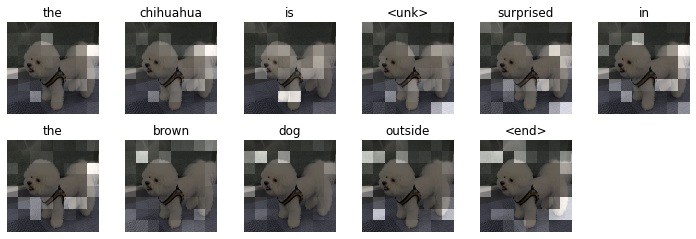

In [4]:
# Max word count for a caption
MAX_LENGTH = 50
# Use the top VOCABULARY_SIZE words for a vocabulary
VOCABULARY_SIZE = 7000
# Calculates the max_length, which is used to store the attention weights
max_length = 52
units = 512
attention_features_shape = 64

# Load tokenizer pickle file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def standardize(inputs):
    inputs = tf.strings.lower(inputs) # convert to lowercase
    return tf.strings.regex_replace(inputs, # change input into
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "") # pattern -> rewrite 

# Image preprocessing
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load InceptionV3 model with pretrained Imagenet weights

image_model = tf.keras.applications.InceptionV3(include_top=False, # does not include fully connected layer('top')
                                                weights='imagenet' # load pretrained weights
                                               )

# Use only certain parts of the model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output # in this case, using all the layers of InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 

def evaluate(image, encoder, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)
    hidden = tf.zeros((1, units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot


# Show original image(image), created words(result), (attention_plot) 
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image)) # load original image into array

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result) 
    for i in range(len_result): # show plot with each created words
        temp_att = np.resize(attention_plot[i], (8, 8)) # resize attention_plot
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(int(grid_size), int(grid_size), i + 1)
        ax.set_title(result[i]) # show each created word
        img = ax.imshow(temp_image)
        plt.axis('off')
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent()) # show original image with attention_plot

    plt.tight_layout()
    plt.show()
    
test_image_path = os.getcwd() + '.\\test_images\\jango.jpg'

result, attention_plot = evaluate(
    test_image_path,
    encoder=tf.keras.models.load_model('my_encoder'),
    decoder=tf.keras.models.load_model('my_decoder'),
)

# Remove [UNK], <end>
prediction_result = []
for word in result:
    if word not in ['[UNK]', '<end>']:
        prediction_result.append(word)

prediction_string = ' '.join(prediction_result)

print('Prediction Caption:', prediction_string)
plot_attention(test_image_path, result, attention_plot)


# Translation

In [5]:
def EngtoKor(txt_eng):
    txt=txt_eng+'.'
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_experimental_option('detach',True)
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

    #driver.maximize_window()

    driver.get('https://papago.naver.com/')
    time.sleep(3)

    # 번역할 내용 입력
    driver.find_element(By.CLASS_NAME, 'edit_box___1KtZ3').send_keys(txt)
    time.sleep(1)

    # 번역 버튼 클릭
    driver.find_element(By.CLASS_NAME, 'btn_text___3-laJ').click()
    time.sleep(3)

    # 번역된 내용 복사 버튼 눌러 복사하기
    driver.find_element(By.XPATH, '//*[@id="root"]/div/div[1]/section/div/div[1]/div[2]/div/div[7]/span[2]/span/span/button').click()
    time.sleep(2)

    result = clipboard.paste()
    return str(result)

translation_result = EngtoKor(prediction_string)
print(translation_result)


치와와는 밖에 있는 갈색 개에게 놀란다.


# TTS

In [6]:
def speak(text):

     tts = gTTS(text=text, lang='ko')
     filename='test.mp3'

     tts.save(filename)
     playsound.playsound(filename)


speak(translation_result)